# MODEL TRAINING - PIPELINE

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path("..") / "02_src"))

In [75]:
# ----------------------------------
# IMPORTS
#-----------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.preprocessing import RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

In [3]:
# get main, clean prepared df 
from model_pipeline import data_preparation
df = data_preparation()

In [93]:
# ----------------------------------
# HELPER - MEAN TARGET VARIABLE
#-----------------------------------
def target_mean():
    target = df["child_mortality_igme"]
    target_mean = target.mean()
    print(f"\nMean Target: {round(target_mean, 2)}")
    return target_mean

In [112]:
# ----------------------------------
# RESIDUAL PLOT
#-----------------------------------
def residual_plot(y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    sns.residplot(x=y_predicts, y=residuals, lowess=True, line_kws=dict(color="r"))
    plt.title(f"Residual-Plot for {model}")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals (y_train - y_predicted)")
    plt.show()

def residuals_hist(residuals, model):
    plt.figure(figsize=(10,4))
    sns.histplot(residuals)
    plt.title(f"Resiudals Histogram for {model}")
    plt.show()

In [167]:
# -----------------------------------
# SCATTERPLOT PREDICTED VS REAL
#------------------------------------
def actual_vs_predicted(y_true, y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    ax = sns.scatterplot(x=y_true, y=y_predicts, hue=residuals, size=residuals)
    
    plt.axline((0,0), slope=1) #https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
    ax.set_xlim(-15, y_true.max())
    ax.set_ylim(-15, y_true.max())
    
    plt.title(f"Comparison Predicted vs Real Target for {model}")
    plt.ylabel("Predicted Target")
    plt.xlabel("Real Target")
    plt.show()

### PIPELINE

In [95]:
# ----------------------------------
# VARIABLES: Features, Target, Group
#-----------------------------------

y = df["child_mortality_igme"]
X = df.drop(columns=["Code", "Year", "Entity", "child_mortality_igme"])
group = df["Entity"]

num_variables = X.drop(columns=["world_regions_wb"]).columns.to_list()
cat_variables = ["world_regions_wb"]
regions_list = X["world_regions_wb"].unique()

#year_col = ["Year"]

In [96]:
# ----------------------------------
# Train/Test Split
#-----------------------------------

gs_split = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=99)
train_index, test_index = next(gs_split.split(X, y, group))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
group_train = group.iloc[train_index]
group_test  = group.iloc[test_index]

In [97]:
# Combis
def comb_feature(X):
    X = X.copy()
    X["bip_water"] = X["nurses_and_midwives_per_1000_people"] * X["physicians_per_1000_people"]
    return X[["bip_water"]]

comb_features = FunctionTransformer(comb_feature)

In [98]:
# -------------------------------------
# KMeans Cluster außerhalb der Pipeline
#--------------------------------------

X_train_cluster = X_train[num_variables].copy()

kmeans_rscaler = RobustScaler()
X_kmeans_scaled = kmeans_rscaler.fit_transform(X_train_cluster)

knn_impute = KNNImputer(n_neighbors=5, weights="distance")
X_kmeans_imputed = knn_impute.fit_transform(X_kmeans_scaled)

km_train = KMeans(n_clusters=6, random_state=99)
km_train.fit(X_kmeans_imputed)

km_dist_train = km_train.transform(X_kmeans_imputed)

km_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_train.shape[1])]
kmeans_cluster_columns = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_train.copy().index)
X_cl_train = pd.concat([X_train.copy(), kmeans_cluster_columns], axis=1)

In [99]:
# ------------------------------------------
# Preprocessing, Training & CROSS VALIDATION
#------------------------------------------

# handle numeric variables
num_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    ("transformer", PowerTransformer())
])

# handle categoric variable
cat_pipeline = Pipeline([
    ("ohe", OneHotEncoder(
        drop = "first",
        handle_unknown = "error",
        categories=[regions_list],
        sparse_output=False
    ))
])
               
preprocessor = ColumnTransformer(transformers=[
    ("numeric", num_pipeline, num_variables),
    ("categoric", cat_pipeline, cat_variables),
    #("comb_features", comb_features, ["nurses_and_midwives_per_1000_people", "physicians_per_1000_people"]),
    #("drop_cols", "drop", year_col)
], remainder="passthrough")

gk = GroupKFold(n_splits=5)

### BASELINE MODEL (LINEAR REGRESSION)

In [102]:
# -------------------------------------------------
# BASELINE MODEL: LINEAR REGRESSION  NON-REGULARIZED
#--------------------------------------------------
lr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])
#Target is rightskewed, logtransform y before training
lr_pipeline_y_log  = TransformedTargetRegressor(
    regressor=lr_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

lr_mae_cv = cross_val_score(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk, scoring="neg_mean_absolute_error")
lr_rmse_cv = cross_val_score(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk, scoring="neg_root_mean_squared_error")
lr_mae_score = -lr_mae_cv
lr_rmse_score = -lr_rmse_cv

print("\n------LINEAR REGRESSION CV SCORES--------")
print("\nMAE:")
print(f"MAE error in relation to mean target: {round( (lr_mae_score.mean() / target_mean()) * 100, 2 )} %")
print(f"\nFolds MAE scores: {lr_mae_score}\nMean MAE Score: {lr_mae_score.mean()}\nStd MAE Score: {lr_mae_score.std()}")
print("\nRMSE:")
print(f"\nFolds RMSE scores: {lr_rmse_score}\nMean RMSE Score: {lr_rmse_score.mean()}\nStd RMSE Score: {lr_rmse_score.std()}\n")
print("-----------------------------------------\n")


------LINEAR REGRESSION CV SCORES--------

MAE:

Mean Target: 31.26
MAE error in relation to mean target: 30.25 %

Folds MAE scores: [ 7.87398824  9.67018259 10.51616449  9.77795021  9.43356898]
Mean MAE Score: 9.454370900708593
Std MAE Score: 0.8691059728343316

RMSE:

Folds RMSE scores: [10.61152387 17.35922102 15.7063843  22.19445559 14.3216479 ]
Mean RMSE Score: 16.038646532358925
Std RMSE Score: 3.7986851671944937

-----------------------------------------



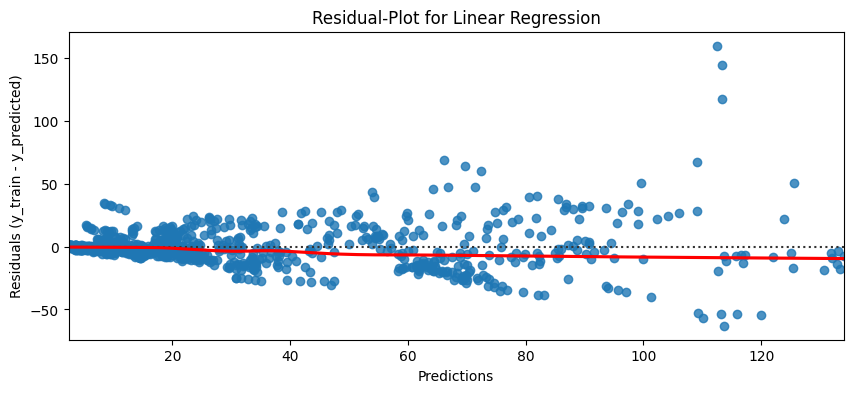

In [113]:
# -------------------------------------------------
# RESIDUAL PLOT FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
lr_y_predicts = cross_val_predict(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk)
lr_residuals = y_train - lr_y_predicts

residual_plot(lr_y_predicts, lr_residuals, "Linear Regression")

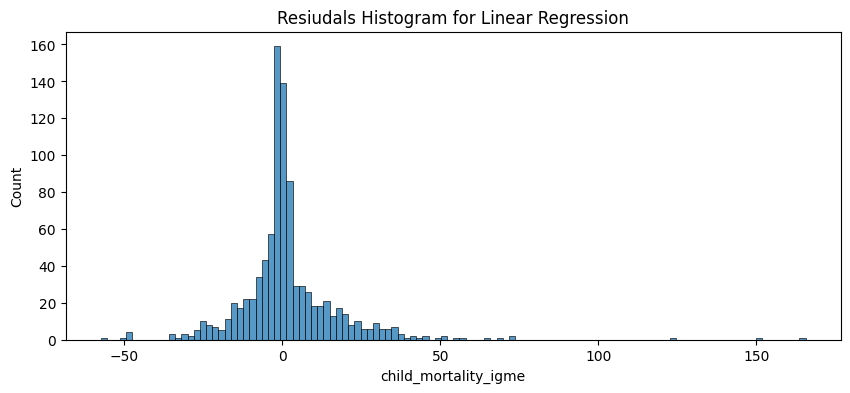

In [114]:
# -------------------------------------------------
# HISTOGRAM PLOT OF RESIDUALS FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
residuals_hist(lr_residuals, "Linear Regression")

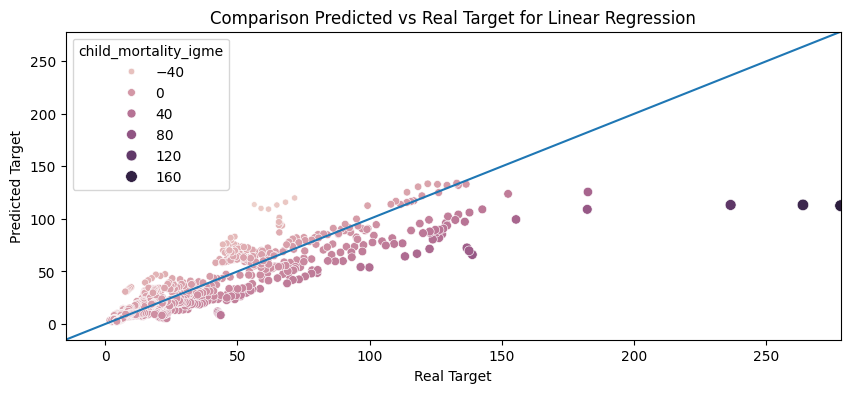

In [168]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
actual_vs_predicted(y_train, lr_y_predicts, lr_residuals, "Linear Regression")